# No Edges

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch_geometric.data import Data, DataLoader
from torch.utils.data import Dataset, DataLoader
from torch_geometric.utils import from_networkx
from torch_geometric.nn import SAGEConv, GCNConv
from torch_geometric.transforms import NormalizeScale

from itertools import product

import h5py

# For ROC Curve
from sklearn.metrics import roc_curve, auc

/Users/pesticci1/Library/Python/3.9/lib/python/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
# Load data
signal_df = pd.read_csv('Dijet_bb_pt10_15_dw.csv')
background_df = pd.read_csv('Dijet_qq_pt10_15_dw.csv')

In [ ]:
# Distinguish signal and background
signal_df['IsB']=1
background_df['IsB']=0

In [ ]:
# Separate Jet 0 and Jet 1 data
sig_jet0 = signal_df[signal_df.columns[signal_df.columns.str.contains("Jet0|IsB")]]
back_jet0 = background_df[background_df.columns[background_df.columns.str.contains("Jet0|IsB")]]

sig_jet1 = signal_df[signal_df.columns[signal_df.columns.str.contains("Jet1|IsB")]]
back_jet1 = background_df[background_df.columns[background_df.columns.str.contains("Jet1|IsB")]]

# Combine signal and background
train_df = pd.concat([sig_jet0, back_jet0])
test_df = pd.concat([sig_jet1, back_jet1])

In [ ]:
# Create Graph with No Edges from Training DataFrame

def no_edges_graph0(df):
    G = nx.Graph()

    nodes = ['Jet0_MM', 'Jet0_PX', 'Jet0_PY', 'Jet0_PZ', 'Jet0_M', 'Jet0_PT', 'Jet0_Eta', 'Jet0_Phi', 'Jet0_NTrk']
    df = df.apply(pd.to_numeric, errors='coerce')

    for node in nodes:
        G.add_node(node)
            
    for node in G.nodes(): 
        feature_cols = df.columns.difference(nodes)  # Exclude node columns
        node_features = df.loc[:, feature_cols].values

        node_features = torch.tensor(node_features.astype(float), dtype=torch.float) # Convert to float
        node_features = torch.nan_to_num(node_features, nan=0.0)  # Replace NaNs with 0.0

        # Avoid warning
        G.nodes[node]['x'] = node_features[0].clone().detach()
    
    
    data = from_networkx(G)
    data.y = torch.ones(data.num_nodes, dtype=torch.long)
    data.train_mask = torch.ones(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.ones(data.num_nodes, dtype=torch.bool)

    return data

In [ ]:
# Create Graph with No Edges from Training DataFrame

def no_edges_graph1(df):
    G = nx.Graph()

    nodes = ['Jet1_MM', 'Jet1_PX', 'Jet1_PY', 'Jet1_PZ', 'Jet1_M', 'Jet1_PT', 'Jet1_Eta', 'Jet1_Phi', 'Jet1_NTrk']
    df = df.apply(pd.to_numeric, errors='coerce')

    for node in nodes:
        G.add_node(node)
            
    for node in G.nodes(): 
        feature_cols = df.columns.difference(nodes)  # Exclude node columns
        node_features = df.loc[:, feature_cols].values

        node_features = torch.tensor(node_features.astype(float), dtype=torch.float) # Convert to float
        node_features = torch.nan_to_num(node_features, nan=0.0)  # Replace NaNs with 0.0

        # Avoid warning
        G.nodes[node]['x'] = node_features[0].clone().detach()
    
    
    data = from_networkx(G)
    data.y = torch.ones(data.num_nodes, dtype=torch.long)
    data.train_mask = torch.ones(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.ones(data.num_nodes, dtype=torch.bool)
    
    return data

In [ ]:
train_graph = no_edges_graph0(train_df)
test_graph = no_edges_graph1(test_df)

In [ ]:
# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(train_graph.num_node_features, 64)
        self.conv2 = GCNConv(64, 2)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return F.log_softmax(x, dim=1)

model = GNN()

In [ ]:
# Training parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(100):
    loss = train(model, train_graph, optimizer, criterion)
    print(f'Epoch {epoch+1}, Loss: {loss}')

# Evaluation
def test(model, data):
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    return acc

accuracy = test(model, test_graph)
print(f'Accuracy: {accuracy}')

Epoch 1, Loss: 97521049600.0
Epoch 2, Loss: 34393755648.0
Epoch 3, Loss: 0.6931471824645996
Epoch 4, Loss: 0.6931471824645996
Epoch 5, Loss: 0.6931471824645996
Epoch 6, Loss: 0.6931471824645996
Epoch 7, Loss: 0.6931471824645996
Epoch 8, Loss: 0.6931471824645996
Epoch 9, Loss: 0.6931471824645996
Epoch 10, Loss: 0.6931471824645996
Epoch 11, Loss: 0.6931471824645996
Epoch 12, Loss: 0.6931471824645996
Epoch 13, Loss: 0.6931471824645996
Epoch 14, Loss: 0.6931471824645996
Epoch 15, Loss: 0.6931471824645996
Epoch 16, Loss: 0.6931471824645996
Epoch 17, Loss: 0.6931471824645996
Epoch 18, Loss: 0.6931471824645996
Epoch 19, Loss: 0.6931471824645996
Epoch 20, Loss: 0.6931471824645996
Epoch 21, Loss: 0.6931471824645996
Epoch 22, Loss: 0.6931471824645996
Epoch 23, Loss: 0.6931471824645996
Epoch 24, Loss: 0.6931471824645996
Epoch 25, Loss: 0.6931471824645996
Epoch 26, Loss: 0.6931471824645996
Epoch 27, Loss: 0.6931471824645996
Epoch 28, Loss: 0.6931471824645996
Epoch 29, Loss: 0.6931471824645996
Epoc

# ROC Curve

background rejection = fraction of events that don't belong in your sample that are excluded from your sample
#
signal efficiency = fraction of the desired events that you actually get

In [ ]:
output = model(test_graph)
_, pred = output.max(dim=1)
true_labels = test_graph.y.numpy().flatten()
y_score = output[:, 1].detach().numpy()

In [ ]:
fpr, tpr, thresholds = roc_curve(true_labels, y_score)
auc = auc(fpr, tpr)

/Users/pesticci1/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


In [ ]:
back_rej = 1 - fpr
sig_eff = 1 - tpr

print(f'Background Rejection: {back_rej}')
print(f'Signal Efficiency: {sig_eff}')
print(f'AUC: {auc}')

Background Rejection: [nan nan]
Signal Efficiency: [1. 0.]
AUC: nan


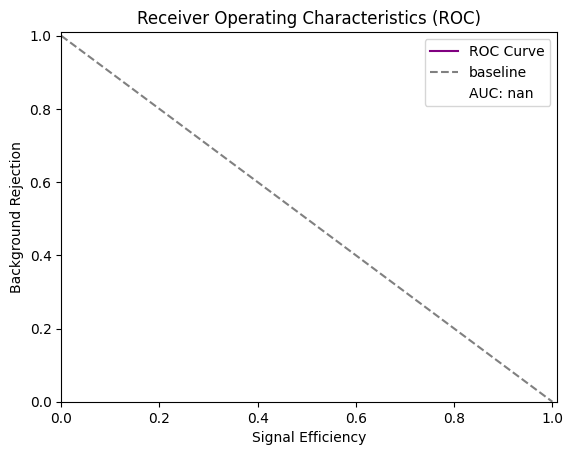

In [ ]:
plt.plot(back_rej, sig_eff, color='purple', label='ROC Curve')
plt.plot([0, 1], [1, 0], color='grey', linestyle='--', label='baseline')
plt.plot([], [], ' ', label=f'AUC: {auc}')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.ylabel('Background Rejection')
plt.xlabel('Signal Efficiency' )
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='best')
plt.show()